In [18]:
#import cv2
import os

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from pathlib import Path
from PIL import Image, ImageDraw
from tensorflow.keras import backend as K
#from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense, Add, Conv2D, SeparableConv2D
from tensorflow.keras.layers import BatchNormalization, AveragePooling2D
from tensorflow.keras.layers import LeakyReLU, MaxPooling2D, Flatten
from tensorflow.keras.models import Model

In [2]:
IMG_HEIGHT = 264
IMG_WIDTH = 640
X_FACTOR = 1
Y_FACTOR = 1
BATCH_SIZE = 128
EPOCHS = 30    # maybe mehr?
learning_rate = 0.003
train_dataset_path = './images/train/'
test_dataset_path = './images/test/'

In [19]:
# Function to read images names and store them in a DataFrame
def grabPaths(filepath):
    labels = [str(filepath[i]).split("/")[-1] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='path').astype(str)
    
    # Concatenate filepaths and labels

    # Shuffle the DataFrame and reset index
    df = pd.DataFrame(filepath)
    
    return df

# Function to scale boxes coordinates (bacuase images are resized)
def resize_boxes(boxes):
    boxes = np.array(boxes).astype(np.float32)
    boxes = boxes * X_FACTOR
    return (np.rint(boxes)).astype(int)


# Function to draw bounding box given an image & coordinates
def plot_bbox(image, yt_box, yp_box=None, norm=False):
    # If image is normalized (/255.) reconstruct (inverse) the operation
    if norm:
        image = image * 255.
        image = image.astype("uint8")
    
    # Convert image to array if not converted
    try:
        pil_img = Image.fromarray(image)
    except:
        pil_img = Image.fromarray(image.astype('uint8'))
        
    draw_img = ImageDraw.Draw(pil_img)
    
    x1, y1, w = yt_box
    h = w
    x2, y2 = x1+w, y1+h
    draw_img.rectangle((x1, y1, x2, y2), outline='green')
    
    # If y_pred box is given, draw it
    if yp_box is not None:
        x1, y1, w = yp_box
        h = w
        x2, y2 = x1+w, y1+h
        draw_img.rectangle((x1, y1, x2, y2), outline='red')
    return pil_img


# Function to build convolutionl block
def convblock(previous_layer, n_filters, filter_windows=(3,3,3), padding='same', pool=None):
    # [DepthwiseConv -> BatchNorm -> LeakyReLU] x3 + Residual connection -> Pooling (optional)

    x = SeparableConv2D(n_filters[0], filter_windows[0], padding=padding)(previous_layer)
    x_short = x
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = SeparableConv2D(n_filters[1], filter_windows[1], padding=padding)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = SeparableConv2D(n_filters[2], filter_windows[2], padding=padding)(x)
    x = BatchNormalization()(x)
    x = Add()([x, x_short])
    x = LeakyReLU()(x)
    
    if pool == 'max':
        x = MaxPooling2D(pool_size=(2,2))(x)
    elif pool == 'avg':
        x = AveragePooling2D(pool_size=(2,2))(x)
    
    return x

# Function to show samples
def visualize_samples(datagen, row_col_len=4, figsize=None):
    figsize = figsize or np.array((row_col_len, row_col_len)) * 4
    fig, ax = plt.subplots(row_col_len*5, row_col_len, figsize=figsize)
    for i in range(row_col_len*5):
        for j in range(row_col_len):
            batch_index = np.random.randint(0, BATCH_SIZE/2)
            output_classes = np.array(datagen[batch_index][1]['class_out'])
            classes_true = np.where(output_classes == 1)[0]
            sample_index = classes_true[np.random.randint(0, classes_true.shape[0])]
            image = datagen[batch_index][0][sample_index]
            print(image.shape)
            box = datagen[batch_index][1]['box_out'][sample_index]
            plotted_box = plot_bbox(image, box, norm=True)
            ax[i,j].imshow(plotted_box)
            ax[i,j].set_axis_off()
            #ax[i,j].title.set_text(str(batch_index*BATCH_SIZE+sample_index))
    plt.show()
    


# Function to make a prediction during training
def visualize_prediction(model, data):    
    # Select a sample where an object exists
    output_classes = np.array(custom_test_gen[0][1]['class_out'])
    sample_index = np.where(output_classes == 1)[0]
    sample_index = sample_index[0] if sample_index[0] else 0 
    
    # Get image
    image = np.array([data[0][0][sample_index]])
    
    # Set y_true & y_pred for class & bounding box
    yt_box = np.array([custom_test_gen[0][1]['box_out'][sample_index]])
    yt_class = np.array([custom_test_gen[0][1]['class_out'][sample_index]])
    yp_class, yp_box = model.predict(image)

    # Plot bounding box on image & show it
    image_plotted = plot_bbox(image[0], yt_box[0], yp_box[0], norm=True) 
    plt.imshow(image_plotted)
    plt.axis('off')
    
    # Print y_true class & y_pred class
    print("Class: y_true=", yt_class, " | y_pred=", int(yp_class >= 0.5))
    plt.show()


# Function to reduce learning rate during training        
def lr_scheduler(epoch, lr):
    if epoch > 10:
        lr = lr * tf.math.exp(-0.1) #-0.15
        print(lr)
    return float(lr)

# Function to calculate MSE Loss function
# for samples where object exists
@tf.keras.saving.register_keras_serializable()
def custom_mse(y_true, y_pred):
    mask = K.not_equal(K.sum(y_true, axis=1), 0.0)
    y_true_custom = y_true[mask]
    y_pred_custom = y_pred[mask]
    mse = tf.keras.losses.MeanSquaredError()
    result = mse(y_true_custom, y_pred_custom) # * 0.3
    return result

In [4]:
# Read CSV
train_dataset = pd.read_csv('./images/train/dataset.csv')
train_dataset.columns = ['path', 'ball_exists', 'x', 'y', 'w', 'h']
test_dataset = pd.read_csv('./images/test/dataset.csv')
test_dataset.columns = ['path', 'ball_exists', 'x', 'y', 'w', 'h']


# List directories of files
train_image_dir_hand = Path('./images/train')
train_filepaths_hand = list(train_image_dir_hand.glob(r'**/*.jpg'))
test_image_dir_hand = Path('./images/test')
test_filepaths_hand = list(train_image_dir_hand.glob(r'**/*.jpg'))

# Create dataframe of {paths, labels}
train_df_hand = grabPaths(train_filepaths_hand)
test_df_hand = grabPaths(test_filepaths_hand)

train_dataset['path'] = "./images/train/" + train_dataset['path']
test_dataset['path'] = "./images/test/" + test_dataset['path']


# Resize boxes, keep zeros if no object exists
train_dataset.iloc[:,2:] = resize_boxes(train_dataset.iloc[:,2:])
test_dataset.iloc[:,2:] = resize_boxes(test_dataset.iloc[:,2:])

[Text(0.5, 0, 'Object exists in image'), Text(0, 0.5, 'No. of Image')]

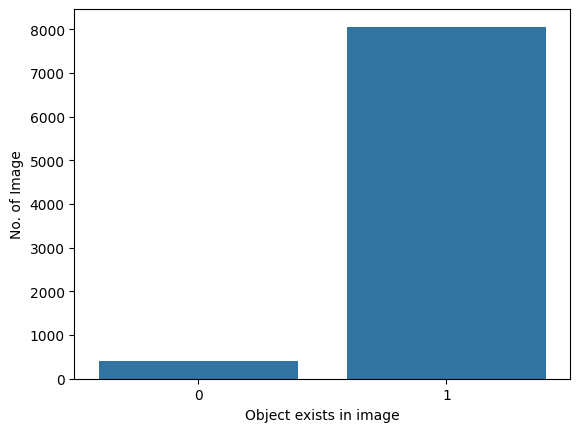

In [5]:
ax = sns.countplot(x='ball_exists', data=train_dataset)
ax.set(xlabel='Object exists in image', ylabel='No. of Image')

In [6]:
# balance dataset (undersampling)
# balls = dataset[dataset['ball_exists'] == 1]
# noballs = dataset[dataset['ball_exists'] == 0]
# balls = balls.sample(frac=0.75).reset_index(drop=True)

# # merge balanced classes & shuffle
# train_df = pd.concat((balls, noballs)).sample(frac=1.).reset_index(drop=True)

# train_df, test_df = train_test_split(train_df, test_size=0.2)

# print(f"No. Training Samples: {train_df.shape[0]}\nNo. Validation Samples: {test_df.shape[0]}")

In [7]:
# Create custom Generator for multiple output models
class MultiOutputGen(tf.keras.utils.Sequence):
    def __init__(self, input_gen, output_gen):
        self.inpgen = input_gen
        self.outgen = output_gen
#         assert len(input_gen) == len(output_gen)

    def __len__(self):
        return len(self.inpgen)

    def __getitem__(self, i):
        images = self.inpgen[i]
        start = i * images.shape[0]
        end = (i+1) * images.shape[0]
        classes_num = self.outgen.iloc[start:end,0].values
        x = self.outgen.iloc[start:end,1]
        y = self.outgen.iloc[start:end,2]
        w = self.outgen.iloc[start:end,3]
#         h = self.outgen.iloc[start:end,4]
        return images, {'class_out':classes_num, 'box_out':np.array([x, y, w]).T}

    def on_epoch_end(self):
        self.inpgen.on_epoch_end()
    
# Class to visualize predictions during training
class ConvergenceVisualization(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        global custom_test_gen
        visualize_prediction(self.model, custom_test_gen)

In [8]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    brightness_range=(0.8, 1.2),
    rescale = 1./255.,
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255.,
)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_dataset,
    x_col='path',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    color_mode='rgb',
    class_mode=None,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_dataset,
    x_col='path',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    color_mode='rgb',
    class_mode=None,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

# Create multi-output generator
custom_train_gen = MultiOutputGen(train_images, train_dataset.iloc[:,1:])
custom_test_gen = MultiOutputGen(test_images, test_dataset.iloc[:,1:])

Found 8458 validated image filenames.
Found 637 validated image filenames.


(264, 640, 3)
(264, 640, 3)


ValueError: high <= 0

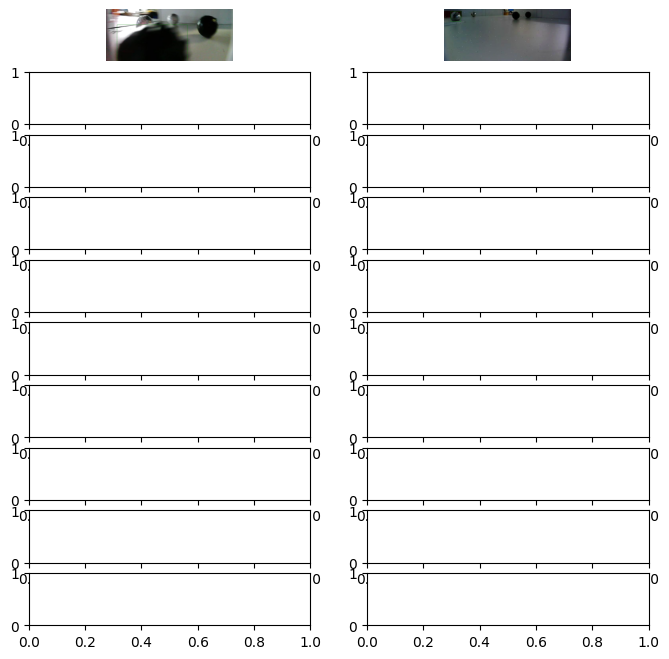

In [20]:
visualize_samples(custom_train_gen, 2)

In [10]:
# BEST MODEL

inp = Input(shape=(IMG_HEIGHT,IMG_WIDTH,3), name='image')

X = SeparableConv2D(64, (7,7), strides=2, padding='valid')(inp)
X = MaxPooling2D(pool_size=(2,2), strides=2)(X)

X = SeparableConv2D(192, (3,3), strides=1, padding='same')(X)
X = MaxPooling2D(pool_size=(2,2), strides=2)(X)

X = convblock(X, [16, 16, 16], pool='max')
X = convblock(X, [32, 32, 32], pool='max')
X = convblock(X, [64, 64, 64], pool='max')
X = convblock(X, [128, 128, 128], pool='max')
X = convblock(X, [256, 256, 256])

X = Flatten()(X)
boxX = Dense(512)(X)
boxX = LeakyReLU()(boxX)

classX = Dense(128)(X)
classX = LeakyReLU()(classX)

box_out = Dense(3, name='box_out')(boxX)
class_out = Dense(1, name='class_out', activation='sigmoid')(classX)


model = Model(inp, [class_out, box_out])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)            │ (None, 264, 640, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv2d              │ (None, 129, 317, 64)      │             403 │ image[0][0]                │
│ (SeparableConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 64, 158, 64)       │               0 │ separable_conv2d[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv2d_1            │ (None, 64, 158, 192)      │          13,056 │ max_pooling2d[0][0]        │
│ (SeparableConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_1               │ (None, 32, 79, 192)       │               0 │ separable_conv2d_1[0][0]   │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv2d_2            │ (None, 32, 79, 16)        │           4,816 │ max_pooling2d_1[0][0]      │
│ (SeparableConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 32, 79, 16)        │              64 │ separable_conv2d_2[0][0]   │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ leaky_re_lu (LeakyReLU)       │ (None, 32, 79, 16)        │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv2d_3            │ (None, 32, 79, 16)        │             416 │ leaky_re_lu[0][0]          │
│ (SeparableConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 32, 79, 16)        │              64 │ separable_conv2d_3[0][0]   │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ leaky_re_lu_1 (LeakyReLU)     │ (None, 32, 79, 16)        │               0 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv2d_4            │ (None, 32, 79, 16)        │             416 │ leaky_re_lu_1[0][0]        │
│ (SeparableConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2         │ (None, 32, 79, 16)        │              64 │ separable_conv2d_4[0][0]   │
│ (BatchNormalization)          │                           │               

 Total params: 1,567,927 (5.98 MB)

 Trainable params: 1,564,951 (5.97 MB)

 Non-trainable params: 2,976 (11.62 KB)

In [11]:
adam = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(
    loss={
        "box_out":custom_mse,
        'class_out':'binary_crossentropy'
    },
    metrics={
        'class_out':'accuracy'
    },
    optimizer=adam
)

C:\Users\Salkin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step- box_out_loss: 13660.0176 - class_out_accuracy: 0.9422 - class_out_loss: 2.3750 - loss: 13189.4648     
Class: y_true= [1]  | y_pred= 1


C:\Users\Salkin\AppData\Local\Temp\ipykernel_11756\2938820337.py:117: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("Class: y_true=", yt_class, " | y_pred=", int(yp_class >= 0.5))


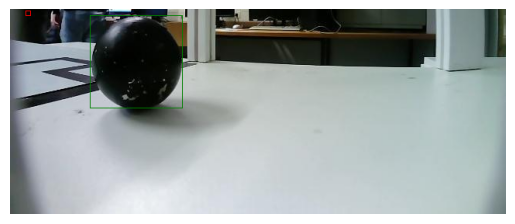

67/67 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - box_out_loss: 13591.4785 - class_out_accuracy: 0.9418 - class_out_loss: 2.3829 - loss: 13123.6514 - val_box_out_loss: 14805.3105 - val_class_out_accuracy: 0.3721 - val_class_out_loss: 1.2867 - val_loss: 14876.3203 - learning_rate: 0.0030
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/steptep - box_out_loss: 5915.4341 - class_out_accuracy: 0.8859 - class_out_loss: 0.4281 - loss: 5783.8647 
Class: y_true= [1]  | y_pred= 1


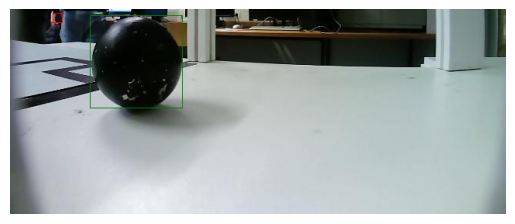

67/67 ━━━━━━━━━━━━━━━━━━━━ 56s 834ms/step - box_out_loss: 5921.3145 - class_out_accuracy: 0.8865 - class_out_loss: 0.4258 - loss: 5788.9580 - val_box_out_loss: 12440.6768 - val_class_out_accuracy: 0.3721 - val_class_out_loss: 2.1885 - val_loss: 12501.4492 - learning_rate: 0.0030
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/steptep - box_out_loss: 5693.7646 - class_out_accuracy: 0.9070 - class_out_loss: 0.7313 - loss: 5656.5928     
Class: y_true= [1]  | y_pred= 1


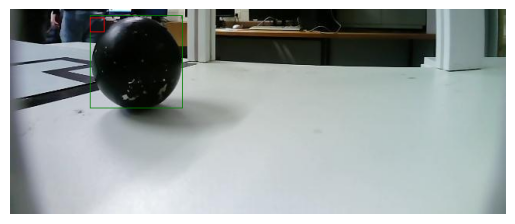

67/67 ━━━━━━━━━━━━━━━━━━━━ 56s 835ms/step - box_out_loss: 5690.3447 - class_out_accuracy: 0.9072 - class_out_loss: 0.7285 - loss: 5651.7847 - val_box_out_loss: 9750.8809 - val_class_out_accuracy: 0.3721 - val_class_out_loss: 1.5892 - val_loss: 9798.3877 - learning_rate: 0.0030
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/steptep - box_out_loss: 4367.0488 - class_out_accuracy: 0.9373 - class_out_loss: 0.5384 - loss: 4352.2095 
Class: y_true= [1]  | y_pred= 1


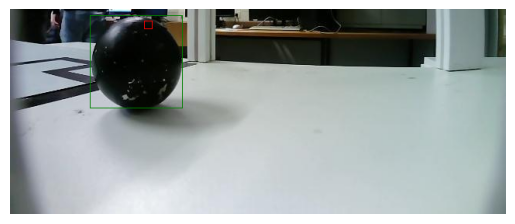

67/67 ━━━━━━━━━━━━━━━━━━━━ 57s 846ms/step - box_out_loss: 4367.5244 - class_out_accuracy: 0.9370 - class_out_loss: 0.5386 - loss: 4351.1270 - val_box_out_loss: 7434.0400 - val_class_out_accuracy: 0.3721 - val_class_out_loss: 9.4440 - val_loss: 7478.4688 - learning_rate: 0.0030
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/steptep - box_out_loss: 4018.0879 - class_out_accuracy: 0.8887 - class_out_loss: 1.7002 - loss: 3717.3762     
Class: y_true= [1]  | y_pred= 1


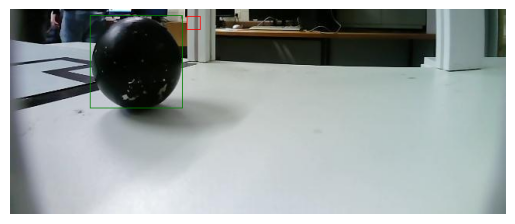

67/67 ━━━━━━━━━━━━━━━━━━━━ 56s 832ms/step - box_out_loss: 4018.6885 - class_out_accuracy: 0.8892 - class_out_loss: 1.6893 - loss: 3719.5483 - val_box_out_loss: 5759.9272 - val_class_out_accuracy: 0.3721 - val_class_out_loss: 7.9985 - val_loss: 5795.0312 - learning_rate: 0.0030
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/steptep - box_out_loss: 2822.7002 - class_out_accuracy: 0.9661 - class_out_loss: 0.3820 - loss: 2775.3345 
Class: y_true= [1]  | y_pred= 0


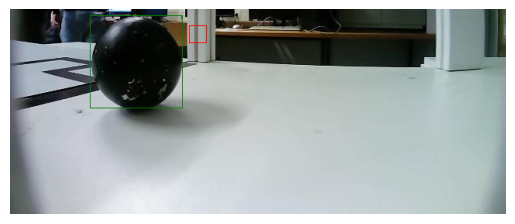

67/67 ━━━━━━━━━━━━━━━━━━━━ 56s 827ms/step - box_out_loss: 2825.0334 - class_out_accuracy: 0.9658 - class_out_loss: 0.3826 - loss: 2776.0994 - val_box_out_loss: 4504.2510 - val_class_out_accuracy: 0.6562 - val_class_out_loss: 0.5936 - val_loss: 4526.0586 - learning_rate: 0.0030
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/steptep - box_out_loss: 2343.8499 - class_out_accuracy: 0.9344 - class_out_loss: 0.3785 - loss: 2308.9465 
Class: y_true= [1]  | y_pred= 1


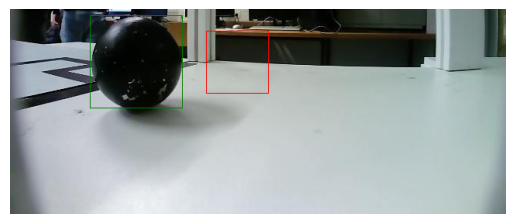

67/67 ━━━━━━━━━━━━━━━━━━━━ 56s 827ms/step - box_out_loss: 2344.7744 - class_out_accuracy: 0.9345 - class_out_loss: 0.3782 - loss: 2308.1611 - val_box_out_loss: 2153.1433 - val_class_out_accuracy: 0.3721 - val_class_out_loss: 1.4598 - val_loss: 2164.7395 - learning_rate: 0.0030
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/steptep - box_out_loss: 1981.9965 - class_out_accuracy: 0.9533 - class_out_loss: 0.2610 - loss: 1954.6108 
Class: y_true= [1]  | y_pred= 1


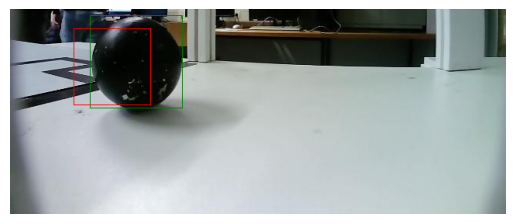

67/67 ━━━━━━━━━━━━━━━━━━━━ 56s 840ms/step - box_out_loss: 1982.2346 - class_out_accuracy: 0.9532 - class_out_loss: 0.2612 - loss: 1953.1810 - val_box_out_loss: 2291.8364 - val_class_out_accuracy: 0.3721 - val_class_out_loss: 4.4240 - val_loss: 2307.0439 - learning_rate: 0.0030
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/steptep - box_out_loss: 2140.2310 - class_out_accuracy: 0.9735 - class_out_loss: 0.1317 - loss: 1956.4753 
Class: y_true= [1]  | y_pred= 1


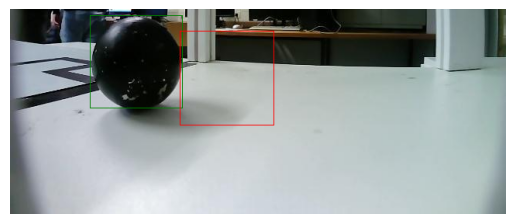

67/67 ━━━━━━━━━━━━━━━━━━━━ 56s 837ms/step - box_out_loss: 2144.2937 - class_out_accuracy: 0.9726 - class_out_loss: 0.1354 - loss: 1960.6018 - val_box_out_loss: 9952.7031 - val_class_out_accuracy: 0.3721 - val_class_out_loss: 5.2377 - val_loss: 10004.7979 - learning_rate: 0.0030
Epoch 10/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/steptep - box_out_loss: 2081.9565 - class_out_accuracy: 0.9596 - class_out_loss: 0.1527 - loss: 1786.8557 
Class: y_true= [1]  | y_pred= 1


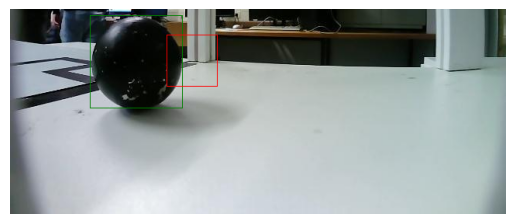

67/67 ━━━━━━━━━━━━━━━━━━━━ 56s 826ms/step - box_out_loss: 2078.8643 - class_out_accuracy: 0.9590 - class_out_loss: 0.1554 - loss: 1785.5052 - val_box_out_loss: 2275.3286 - val_class_out_accuracy: 0.3721 - val_class_out_loss: 1.4477 - val_loss: 2287.4883 - learning_rate: 0.0030
Epoch 11/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/steptep - box_out_loss: 1325.1238 - class_out_accuracy: 0.9336 - class_out_loss: 0.2538 - loss: 1259.8087 
Class: y_true= [1]  | y_pred= 1


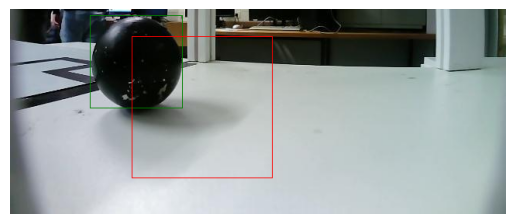

67/67 ━━━━━━━━━━━━━━━━━━━━ 56s 837ms/step - box_out_loss: 1326.3519 - class_out_accuracy: 0.9335 - class_out_loss: 0.2548 - loss: 1259.5624 - val_box_out_loss: 2036.8264 - val_class_out_accuracy: 0.3721 - val_class_out_loss: 1.9731 - val_loss: 2048.3860 - learning_rate: 0.0030
tf.Tensor(0.0027145124, shape=(), dtype=float32)
Epoch 12/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/steptep - box_out_loss: 1875.1271 - class_out_accuracy: 0.9510 - class_out_loss: 0.2261 - loss: 1698.8550 
Class: y_true= [1]  | y_pred= 1


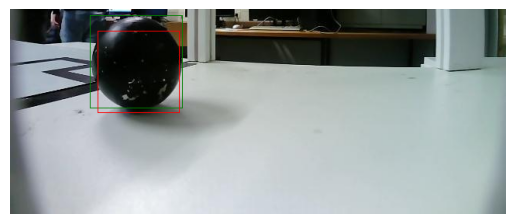

67/67 ━━━━━━━━━━━━━━━━━━━━ 57s 847ms/step - box_out_loss: 1877.6274 - class_out_accuracy: 0.9509 - class_out_loss: 0.2271 - loss: 1702.4578 - val_box_out_loss: 3220.0176 - val_class_out_accuracy: 0.3721 - val_class_out_loss: 1.7200 - val_loss: 3236.8975 - learning_rate: 0.0027
tf.Tensor(0.0024561924, shape=(), dtype=float32)
Epoch 13/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/steptep - box_out_loss: 1331.7659 - class_out_accuracy: 0.9782 - class_out_loss: 0.1239 - loss: 1315.4095 
Class: y_true= [1]  | y_pred= 1


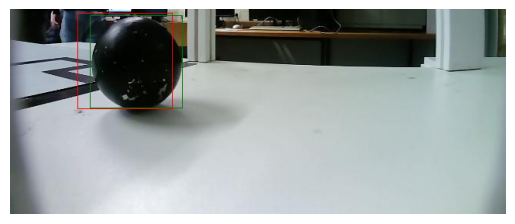

67/67 ━━━━━━━━━━━━━━━━━━━━ 56s 829ms/step - box_out_loss: 1333.9879 - class_out_accuracy: 0.9778 - class_out_loss: 0.1257 - loss: 1315.6801 - val_box_out_loss: 4122.9365 - val_class_out_accuracy: 0.3736 - val_class_out_loss: 1.9295 - val_loss: 4144.2773 - learning_rate: 0.0025
tf.Tensor(0.0022224549, shape=(), dtype=float32)
Epoch 14/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/steptep - box_out_loss: 3922.4441 - class_out_accuracy: 0.9501 - class_out_loss: 0.2251 - loss: 3437.6150 
Class: y_true= [1]  | y_pred= 1


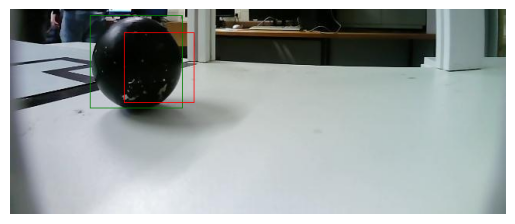

67/67 ━━━━━━━━━━━━━━━━━━━━ 57s 841ms/step - box_out_loss: 3920.2681 - class_out_accuracy: 0.9501 - class_out_loss: 0.2253 - loss: 3436.2888 - val_box_out_loss: 2482.1392 - val_class_out_accuracy: 0.3721 - val_class_out_loss: 2.5874 - val_loss: 2496.4075 - learning_rate: 0.0022
tf.Tensor(0.0020109604, shape=(), dtype=float32)
Epoch 15/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/steptep - box_out_loss: 1857.7656 - class_out_accuracy: 0.9295 - class_out_loss: 0.2931 - loss: 1570.0438 
Class: y_true= [1]  | y_pred= 1


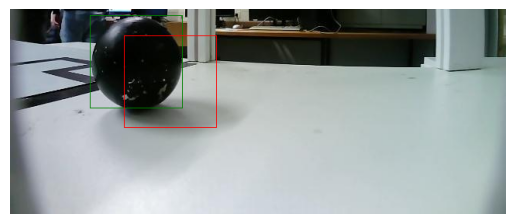

67/67 ━━━━━━━━━━━━━━━━━━━━ 56s 829ms/step - box_out_loss: 1853.5328 - class_out_accuracy: 0.9298 - class_out_loss: 0.2920 - loss: 1568.1954 - val_box_out_loss: 1395.4688 - val_class_out_accuracy: 0.3721 - val_class_out_loss: 2.2664 - val_loss: 1404.3002 - learning_rate: 0.0020
tf.Tensor(0.0018195922, shape=(), dtype=float32)
Epoch 16/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/steptep - box_out_loss: 1076.0858 - class_out_accuracy: 0.9763 - class_out_loss: 0.1119 - loss: 915.3389  
Class: y_true= [1]  | y_pred= 1


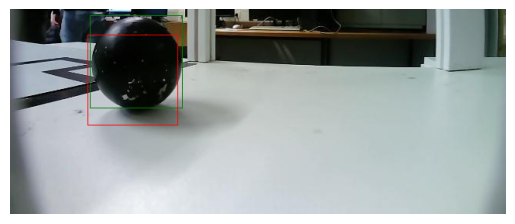

67/67 ━━━━━━━━━━━━━━━━━━━━ 58s 856ms/step - box_out_loss: 1077.1332 - class_out_accuracy: 0.9760 - class_out_loss: 0.1132 - loss: 915.5197 - val_box_out_loss: 1339.4718 - val_class_out_accuracy: 0.3721 - val_class_out_loss: 1.8306 - val_loss: 1347.6047 - learning_rate: 0.0018
tf.Tensor(0.0016464351, shape=(), dtype=float32)
Epoch 17/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/steptep - box_out_loss: 695.0464 - class_out_accuracy: 0.9468 - class_out_loss: 0.2166 - loss: 660.4048 
Class: y_true= [1]  | y_pred= 1


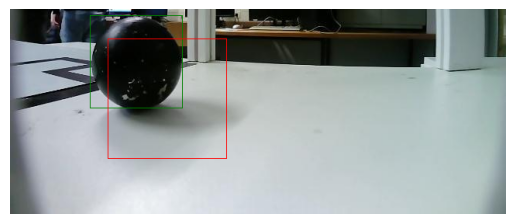

67/67 ━━━━━━━━━━━━━━━━━━━━ 56s 835ms/step - box_out_loss: 697.3748 - class_out_accuracy: 0.9470 - class_out_loss: 0.2165 - loss: 660.8504 - val_box_out_loss: 1552.2289 - val_class_out_accuracy: 0.3736 - val_class_out_loss: 1.0602 - val_loss: 1560.5966 - learning_rate: 0.0016
tf.Tensor(0.0014897562, shape=(), dtype=float32)
Epoch 18/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/steptep - box_out_loss: 589.0644 - class_out_accuracy: 0.9594 - class_out_loss: 0.1801 - loss: 537.0887 
Class: y_true= [1]  | y_pred= 1


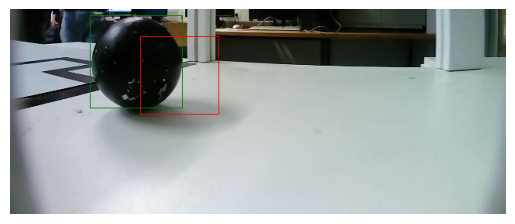

67/67 ━━━━━━━━━━━━━━━━━━━━ 57s 848ms/step - box_out_loss: 589.9183 - class_out_accuracy: 0.9593 - class_out_loss: 0.1802 - loss: 536.8681 - val_box_out_loss: 1556.0277 - val_class_out_accuracy: 0.3721 - val_class_out_loss: 1.6642 - val_loss: 1565.0154 - learning_rate: 0.0015
tf.Tensor(0.0013479871, shape=(), dtype=float32)
Epoch 19/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/steptep - box_out_loss: 552.3668 - class_out_accuracy: 0.9463 - class_out_loss: 0.1991 - loss: 468.6386 
Class: y_true= [1]  | y_pred= 1


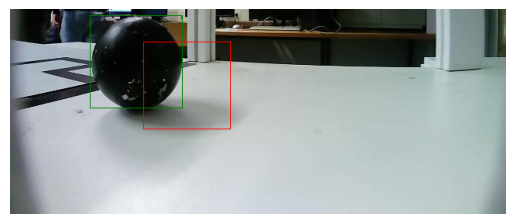

67/67 ━━━━━━━━━━━━━━━━━━━━ 57s 844ms/step - box_out_loss: 552.8254 - class_out_accuracy: 0.9465 - class_out_loss: 0.1988 - loss: 469.1161 - val_box_out_loss: 1521.0156 - val_class_out_accuracy: 0.3721 - val_class_out_loss: 1.5090 - val_loss: 1529.6838 - learning_rate: 0.0013
tf.Tensor(0.0012197092, shape=(), dtype=float32)
Epoch 20/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/steptep - box_out_loss: 417.1408 - class_out_accuracy: 0.9254 - class_out_loss: 0.2326 - loss: 408.9572 
Class: y_true= [1]  | y_pred= 1


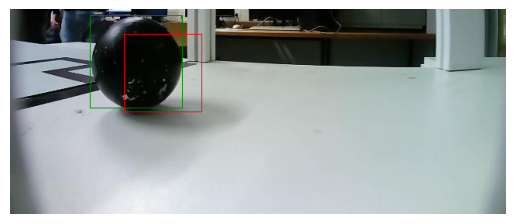

67/67 ━━━━━━━━━━━━━━━━━━━━ 57s 842ms/step - box_out_loss: 419.9017 - class_out_accuracy: 0.9258 - class_out_loss: 0.2315 - loss: 409.1196 - val_box_out_loss: 2053.5242 - val_class_out_accuracy: 0.3721 - val_class_out_loss: 2.7436 - val_loss: 2065.9314 - learning_rate: 0.0012
tf.Tensor(0.0011036386, shape=(), dtype=float32)
Epoch 21/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/steptep - box_out_loss: 1022.0557 - class_out_accuracy: 0.9469 - class_out_loss: 0.2294 - loss: 1007.5413 
Class: y_true= [1]  | y_pred= 1


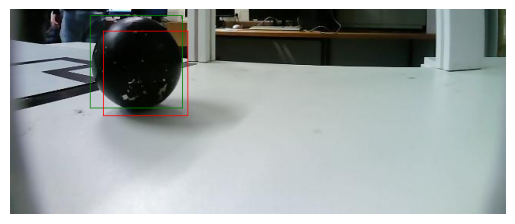

67/67 ━━━━━━━━━━━━━━━━━━━━ 57s 855ms/step - box_out_loss: 1019.5073 - class_out_accuracy: 0.9470 - class_out_loss: 0.2289 - loss: 1003.8550 - val_box_out_loss: 2311.8586 - val_class_out_accuracy: 0.3721 - val_class_out_loss: 1.9983 - val_loss: 2324.7395 - learning_rate: 0.0011
tf.Tensor(0.0009986134, shape=(), dtype=float32)
Epoch 22/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/steptep - box_out_loss: 499.2513 - class_out_accuracy: 0.9366 - class_out_loss: 0.2223 - loss: 483.7659 
Class: y_true= [1]  | y_pred= 1


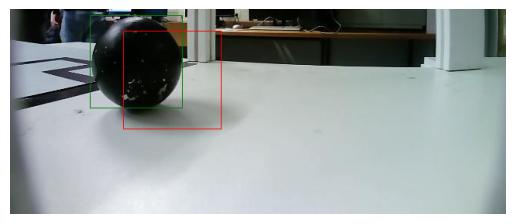

67/67 ━━━━━━━━━━━━━━━━━━━━ 58s 861ms/step - box_out_loss: 499.2219 - class_out_accuracy: 0.9368 - class_out_loss: 0.2215 - loss: 483.3081 - val_box_out_loss: 1420.8582 - val_class_out_accuracy: 0.3721 - val_class_out_loss: 2.1191 - val_loss: 1429.6627 - learning_rate: 9.9861e-04
tf.Tensor(0.0009035828, shape=(), dtype=float32)
Epoch 23/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/steptep - box_out_loss: 342.3814 - class_out_accuracy: 0.9491 - class_out_loss: 0.1831 - loss: 314.4325 
Class: y_true= [1]  | y_pred= 1


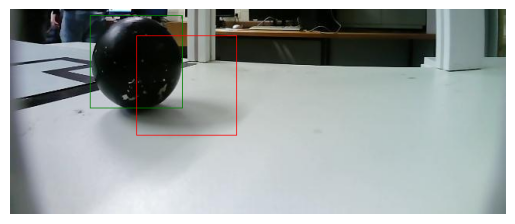

67/67 ━━━━━━━━━━━━━━━━━━━━ 57s 847ms/step - box_out_loss: 342.3960 - class_out_accuracy: 0.9492 - class_out_loss: 0.1830 - loss: 314.4361 - val_box_out_loss: 1511.7216 - val_class_out_accuracy: 0.3721 - val_class_out_loss: 1.6121 - val_loss: 1520.4487 - learning_rate: 9.0358e-04
tf.Tensor(0.0008175955, shape=(), dtype=float32)
Epoch 24/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/steptep - box_out_loss: 313.7465 - class_out_accuracy: 0.9315 - class_out_loss: 0.2074 - loss: 274.0292 
Class: y_true= [1]  | y_pred= 1


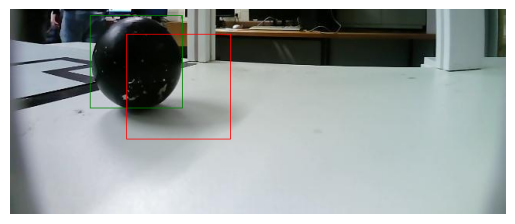

67/67 ━━━━━━━━━━━━━━━━━━━━ 57s 843ms/step - box_out_loss: 313.5349 - class_out_accuracy: 0.9319 - class_out_loss: 0.2068 - loss: 274.0560 - val_box_out_loss: 1505.7976 - val_class_out_accuracy: 0.3721 - val_class_out_loss: 1.5982 - val_loss: 1514.4832 - learning_rate: 8.1760e-04
tf.Tensor(0.000739791, shape=(), dtype=float32)
Epoch 25/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/steptep - box_out_loss: 238.2396 - class_out_accuracy: 0.9340 - class_out_loss: 0.2040 - loss: 232.0149 
Class: y_true= [1]  | y_pred= 1


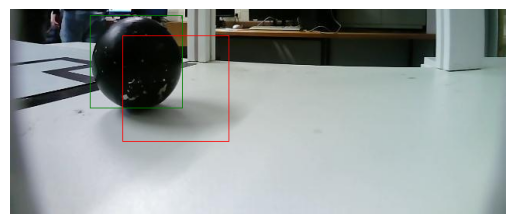

67/67 ━━━━━━━━━━━━━━━━━━━━ 58s 861ms/step - box_out_loss: 238.6713 - class_out_accuracy: 0.9343 - class_out_loss: 0.2033 - loss: 232.1913 - val_box_out_loss: 1565.4856 - val_class_out_accuracy: 0.3721 - val_class_out_loss: 1.9838 - val_loss: 1574.8368 - learning_rate: 7.3979e-04
tf.Tensor(0.0006693906, shape=(), dtype=float32)
Epoch 26/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/steptep - box_out_loss: 257.4749 - class_out_accuracy: 0.8877 - class_out_loss: 0.3492 - loss: 210.6756 
Class: y_true= [1]  | y_pred= 1


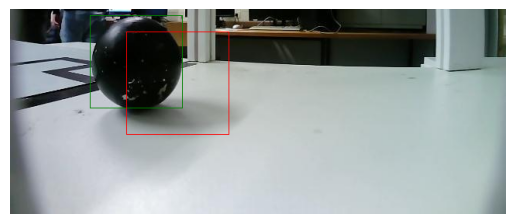

67/67 ━━━━━━━━━━━━━━━━━━━━ 59s 876ms/step - box_out_loss: 257.5242 - class_out_accuracy: 0.8887 - class_out_loss: 0.3467 - loss: 210.9660 - val_box_out_loss: 1488.2350 - val_class_out_accuracy: 0.3721 - val_class_out_loss: 1.9333 - val_loss: 1497.1719 - learning_rate: 6.6939e-04
tf.Tensor(0.00060568965, shape=(), dtype=float32)
Epoch 27/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/steptep - box_out_loss: 379.9583 - class_out_accuracy: 0.9518 - class_out_loss: 0.1628 - loss: 269.1168   
Class: y_true= [1]  | y_pred= 1


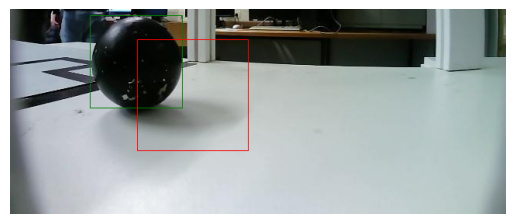

67/67 ━━━━━━━━━━━━━━━━━━━━ 58s 874ms/step - box_out_loss: 378.1566 - class_out_accuracy: 0.9518 - class_out_loss: 0.1627 - loss: 268.5089 - val_box_out_loss: 1611.0562 - val_class_out_accuracy: 0.3721 - val_class_out_loss: 1.4562 - val_loss: 1620.0957 - learning_rate: 6.0569e-04
tf.Tensor(0.0005480507, shape=(), dtype=float32)
Epoch 28/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/steptep - box_out_loss: 282.7671 - class_out_accuracy: 0.9903 - class_out_loss: 0.0604 - loss: 212.0476 
Class: y_true= [1]  | y_pred= 1


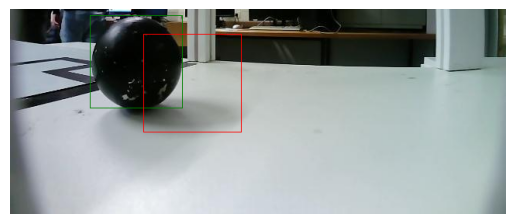

67/67 ━━━━━━━━━━━━━━━━━━━━ 59s 874ms/step - box_out_loss: 281.9856 - class_out_accuracy: 0.9897 - class_out_loss: 0.0618 - loss: 211.8603 - val_box_out_loss: 1617.9065 - val_class_out_accuracy: 0.3721 - val_class_out_loss: 1.5331 - val_loss: 1627.0548 - learning_rate: 5.4805e-04
tf.Tensor(0.0004958968, shape=(), dtype=float32)
Epoch 29/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/steptep - box_out_loss: 173.3343 - class_out_accuracy: 0.9495 - class_out_loss: 0.1686 - loss: 171.7843 
Class: y_true= [1]  | y_pred= 1


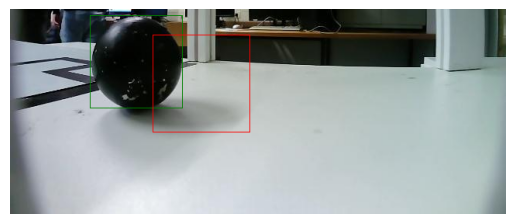

67/67 ━━━━━━━━━━━━━━━━━━━━ 59s 873ms/step - box_out_loss: 173.5667 - class_out_accuracy: 0.9496 - class_out_loss: 0.1685 - loss: 171.8656 - val_box_out_loss: 1543.5648 - val_class_out_accuracy: 0.3721 - val_class_out_loss: 1.5227 - val_loss: 1552.3530 - learning_rate: 4.9590e-04
tf.Tensor(0.00044870598, shape=(), dtype=float32)
Epoch 30/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/steptep - box_out_loss: 212.6260 - class_out_accuracy: 0.9751 - class_out_loss: 0.1038 - loss: 181.7531 
Class: y_true= [1]  | y_pred= 1


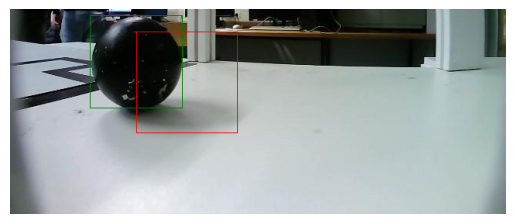

67/67 ━━━━━━━━━━━━━━━━━━━━ 59s 872ms/step - box_out_loss: 212.2157 - class_out_accuracy: 0.9748 - class_out_loss: 0.1046 - loss: 181.6273 - val_box_out_loss: 1607.8025 - val_class_out_accuracy: 0.3721 - val_class_out_loss: 1.3251 - val_loss: 1616.6960 - learning_rate: 4.4871e-04


In [12]:
history = model.fit(
    custom_train_gen,
    epochs=EPOCHS,
    validation_data=custom_test_gen,
    callbacks=[
        tf.keras.callbacks.LearningRateScheduler(lr_scheduler),
        ConvergenceVisualization()
    ]
)

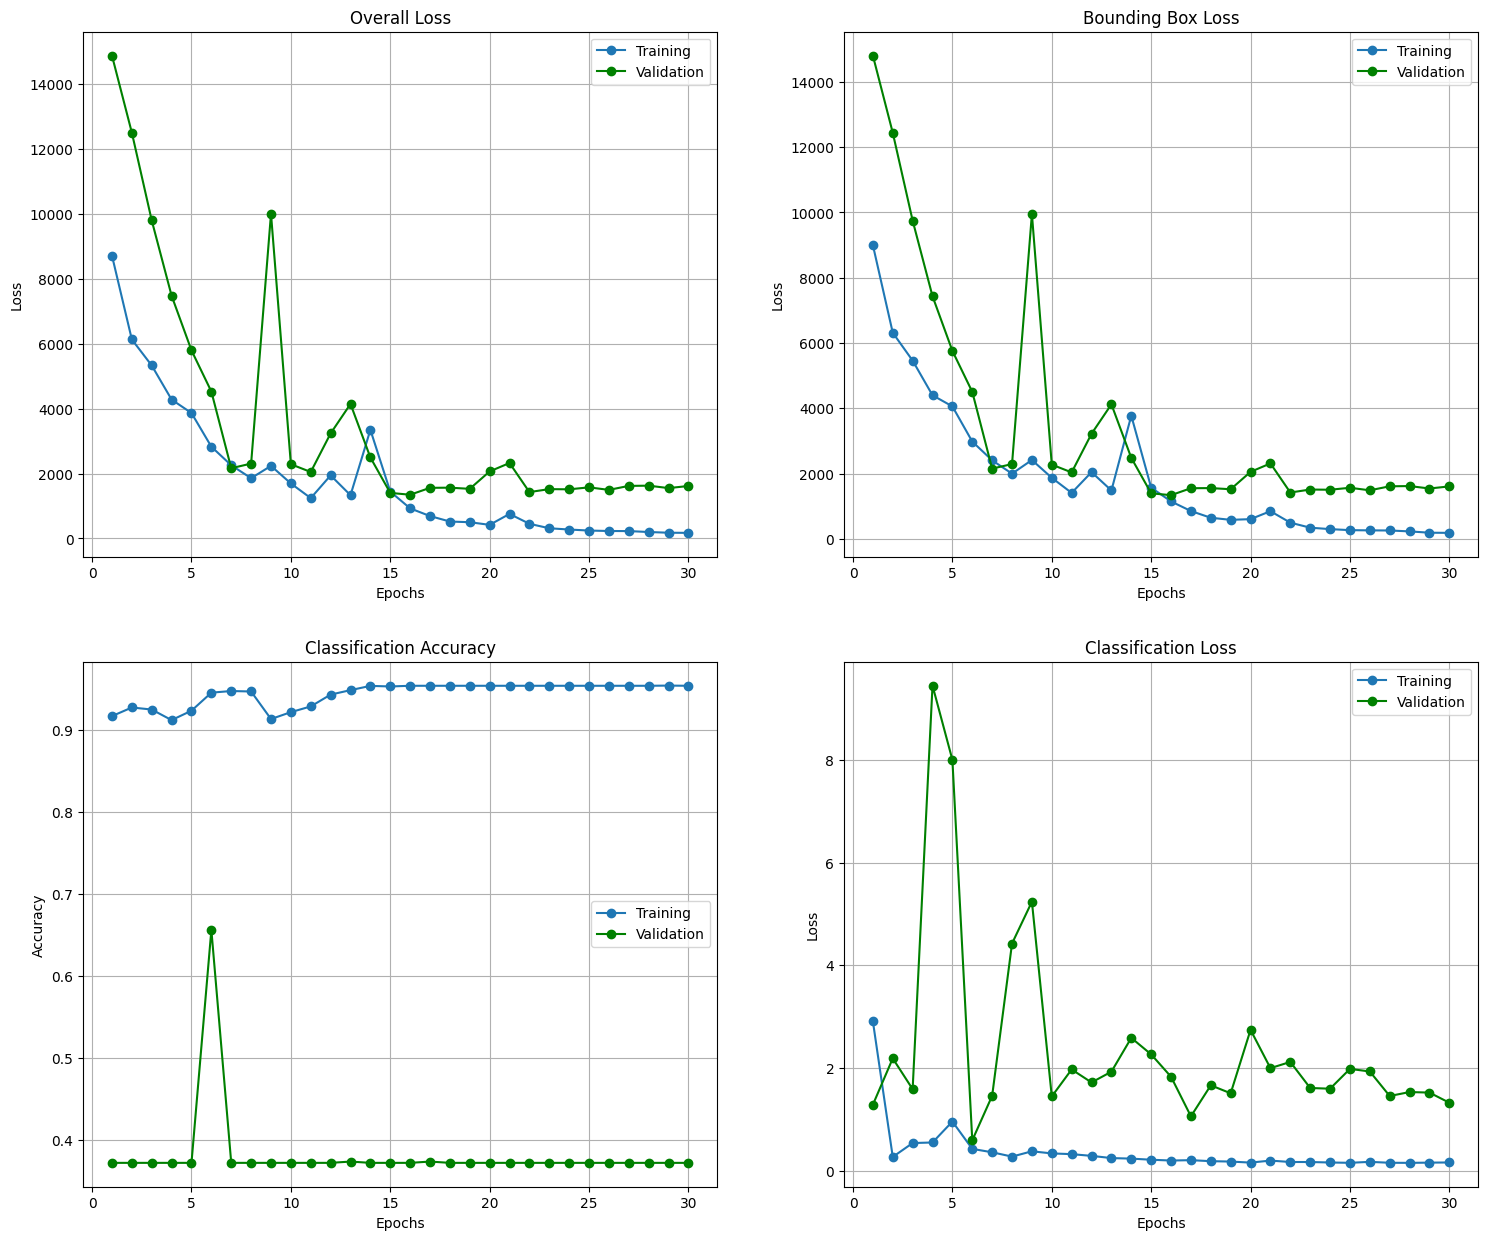

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [13]:
# Accuracy & Loss Visualization

#  Overall Loss
train_overall_loss = history.history['loss']
val_overall_loss = history.history['val_loss']

# Classification Accuracy
train_classification_acc = history.history['class_out_accuracy']
val_classification_acc = history.history['val_class_out_accuracy']

# Classification Loss
train_classification_loss = history.history['class_out_loss']
val_classification_loss = history.history['val_class_out_loss']

# Bounding Box Loss
train_bbox_loss = history.history['box_out_loss']
val_bbox_loss = history.history['val_box_out_loss']

epochs = range(1, len(history.history['loss'])+1)

f, ax = plt.subplots(nrows=2,ncols=2,figsize=(18,15))
    
ax[0,0].plot(epochs, train_overall_loss,  marker='o', label='Training')
ax[0,0].plot(epochs, val_overall_loss, marker='o', color = 'green', label='Validation')
ax[0,0].set_title('Overall Loss')
ax[0,0].set_xlabel('Epochs')
ax[0,0].set_ylabel('Loss')
ax[0,0].legend(loc='best')
ax[0,0].grid(True)

ax[0,1].plot(epochs, train_bbox_loss, marker='o', label='Training')
ax[0,1].plot(epochs, val_bbox_loss, marker='o', color = 'green', label='Validation')
ax[0,1].set_title('Bounding Box Loss')
ax[0,1].set_xlabel('Epochs')
ax[0,1].set_ylabel('Loss')
ax[0,1].legend(loc='best')
ax[0,1].grid(True)



ax[1,0].plot(epochs, train_classification_acc,  marker='o', label='Training')
ax[1,0].plot(epochs, val_classification_acc, marker='o', color = 'green', label='Validation')
ax[1,0].set_title('Classification Accuracy')
ax[1,0].set_xlabel('Epochs')
ax[1,0].set_ylabel('Accuracy')
ax[1,0].legend(loc='best')
ax[1,0].grid(True)

ax[1,1].plot(epochs, train_classification_loss, marker='o', label='Training')
ax[1,1].plot(epochs, val_classification_loss, marker='o', color = 'green', label='Validation')
ax[1,1].set_title('Classification Loss')
ax[1,1].set_xlabel('Epochs')
ax[1,1].set_ylabel('Loss')
ax[1,1].legend(loc='best')
ax[1,1].grid(True)

plt.show()
f.savefig('LossAndAccuracy.eps', format='eps')
plt.close()

In [14]:
#model.save("test1 ball detection.h5")
model.save("ball_detection_V2.keras")

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("ball_detection.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Salkin\AppData\Local\Temp\tmpx50lj_b2\assets


INFO:tensorflow:Assets written to: C:\Users\Salkin\AppData\Local\Temp\tmpx50lj_b2\assets


Saved artifact at 'C:\Users\Salkin\AppData\Local\Temp\tmpx50lj_b2'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 264, 640, 3), dtype=tf.float32, name='image')
Output Type:
  List[TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)]
Captures:
  2082848386768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2082848383696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2082898761232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2082898760656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2082898762768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2082898761616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2082898761808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2082898763152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2082898762960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2082898761040: 

6281364

In [15]:
new_model = tf.keras.models.load_model("ball_detection_V2.keras")
new_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)            │ (None, 264, 640, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv2d              │ (None, 129, 317, 64)      │             403 │ image[0][0]                │
│ (SeparableConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 64, 158, 64)       │               0 │ separable_conv2d[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv2d_1            │ (None, 64, 158, 192)      │          13,056 │ max_pooling2d[0][0]        │
│ (SeparableConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_1               │ (None, 32, 79, 192)       │               0 │ separable_conv2d_1[0][0]   │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv2d_2            │ (None, 32, 79, 16)        │           4,816 │ max_pooling2d_1[0][0]      │
│ (SeparableConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 32, 79, 16)        │              64 │ separable_conv2d_2[0][0]   │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ leaky_re_lu (LeakyReLU)       │ (None, 32, 79, 16)        │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv2d_3            │ (None, 32, 79, 16)        │             416 │ leaky_re_lu[0][0]          │
│ (SeparableConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 32, 79, 16)        │              64 │ separable_conv2d_3[0][0]   │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ leaky_re_lu_1 (LeakyReLU)     │ (None, 32, 79, 16)        │               0 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv2d_4            │ (None, 32, 79, 16)        │             416 │ leaky_re_lu_1[0][0]        │
│ (SeparableConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2         │ (None, 32, 79, 16)        │              64 │ separable_conv2d_4[0][0]   │
│ (BatchNormalization)          │                           │               

 Total params: 4,697,831 (17.92 MB)

 Trainable params: 1,564,951 (5.97 MB)

 Non-trainable params: 2,976 (11.62 KB)

 Optimizer params: 3,129,904 (11.94 MB)

In [37]:
valid_dataset = pd.read_csv('./images/valid/dataset.csv')
#print(valid_dataset)
def visualize_evaluation(model, name):    
    # Get image
    im = Image.open("./images/valid/"+name)
    image = np.expand_dims(np.asarray(im)/255, axis=0)
    print(image.shape)
    print(image)
    
    # Set y_true & y_pred for class & bounding box
    print(valid_dataset.loc[valid_dataset['path']==name]['x'], valid_dataset.loc[valid_dataset['path']==name]['y'], valid_dataset.loc[valid_dataset['path']==name]['w'])
    yt_box = np.array([valid_dataset.loc[valid_dataset['path']==name]['x'], valid_dataset.loc[valid_dataset['path']==name]['y'], valid_dataset.loc[valid_dataset['path']==name]['w']])
    yt_class = np.array(valid_dataset.loc[valid_dataset['path']==name]['ball_exists'])
    
    yp_class, yp_box = model.predict(image)

    camera_fov = 53.50
    angle = (yp_box[0][0]+yp_box[0][2]/2)/640 *camera_fov - camera_fov/2
    print("Ball Angle", angle)

    # Plot bounding box on image & show it
    image_plotted = plot_bbox(image[0], yt_box, yp_box, norm=True) #True?
    plt.imshow(image_plotted)
    plt.axis('off')
    
    # Print y_true class & y_pred class
    print("Class: y_true=", yt_class, " | y_pred=", int(yp_class >= 0.5))
    plt.show()

In [38]:
visualize_evaluation(model, "frame599.jpg")

(1, 264, 640, 3)
[[[[0.56470588 0.69411765 0.71372549]
   [0.56470588 0.69411765 0.71372549]
   [0.56470588 0.69411765 0.71372549]
   ...
   [0.51372549 0.63921569 0.62745098]
   [0.50196078 0.62745098 0.61568627]
   [0.49019608 0.61568627 0.60392157]]

  [[0.56470588 0.69411765 0.71372549]
   [0.56470588 0.69411765 0.71372549]
   [0.56470588 0.69411765 0.71372549]
   ...
   [0.55686275 0.68235294 0.67058824]
   [0.55294118 0.67843137 0.6745098 ]
   [0.54509804 0.67058824 0.65882353]]

  [[0.56470588 0.69411765 0.71372549]
   [0.56470588 0.69411765 0.71372549]
   [0.56862745 0.69803922 0.71764706]
   ...
   [0.56470588 0.69803922 0.69411765]
   [0.56470588 0.69803922 0.70196078]
   [0.56470588 0.69803922 0.69411765]]

  ...

  [[0.73333333 0.79607843 0.74509804]
   [0.73333333 0.79607843 0.74509804]
   [0.73333333 0.79607843 0.74509804]
   ...
   [0.51764706 0.60784314 0.57647059]
   [0.51764706 0.60784314 0.57647059]
   [0.51764706 0.60784314 0.57647059]]

  [[0.73333333 0.79607843 0.

TypeError: Cannot handle this data type: (1, 1, 640, 3), |u1

In [25]:
def visu_tets(sample_index):
    data = custom_test_gen
    image = np.array([data[0][0][sample_index]])
    yt_box = np.array([custom_test_gen[0][1]['box_out'][sample_index]])
    yt_class = np.array([custom_test_gen[0][1]['class_out'][sample_index]])
    yp_class, yp_box = model.predict(image)
    print(image.shape)
    print(image)
    print(image[0].shape)
    image_plotted = plot_bbox(image[0], yt_box[0], yp_box[0], norm=True) 
    plt.imshow(image_plotted)
    plt.axis('off')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
(1, 264, 640, 3)
[[[[0.29803923 0.32156864 0.3137255 ]
   [0.29803923 0.32156864 0.3137255 ]
   [0.2901961  0.3137255  0.30588236]
   ...
   [0.24705884 0.29803923 0.19607845]
   [0.25490198 0.3019608  0.21568629]
   [0.25882354 0.30588236 0.227451  ]]

  [[0.29803923 0.32156864 0.3137255 ]
   [0.29411766 0.31764707 0.30980393]
   [0.2901961  0.3137255  0.30588236]
   ...
   [0.24705884 0.29803923 0.19607845]
   [0.25490198 0.3019608  0.21568629]
   [0.25882354 0.30588236 0.227451  ]]

  [[0.29803923 0.32156864 0.3137255 ]
   [0.29411766 0.31764707 0.30980393]
   [0.2901961  0.3137255  0.30588236]
   ...
   [0.2509804  0.3019608  0.20000002]
   [0.25490198 0.3019608  0.21568629]
   [0.2627451  0.30980393 0.23137257]]

  ...

  [[0.3137255  0.32156864 0.31764707]
   [0.30588236 0.32156864 0.31764707]
   [0.30588236 0.32156864 0.31764707]
   ...
   [0.42352945 0.48627454 0.48627454]
   [0.41960788 0.48235297 0.48235297]
   [0.4156863  0.4784314  0.47

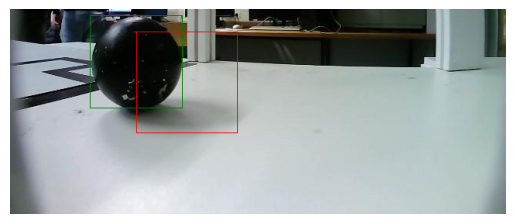

In [26]:
visu_tets(0)